In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader
from wilds.common.grouper import CombinatorialGrouper
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from tqdm import tqdm
from erm_helpers import *
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import sys
import os
import time
from Classifier import Classifier
from SubsampledDataset import SubsampledDataset
from torchsummary import summary


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# device = "cpu"
BATCH_SIZE = 64

cuda


<font size="6">Load train and validation data</font>

In [3]:
dataset = get_dataset(dataset="fmow", download=False)
grouper = CombinatorialGrouper(dataset, ["region"])

train_data = dataset.get_subset(
    "train",
    transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)

ood_val_data = dataset.get_subset(
    "val",
    transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)

id_val_data = dataset.get_subset(
    "id_val",
    transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)

train_dataset = SubsampledDataset(train_data, grouper)
ood_val_dataset = SubsampledDataset(ood_val_data, grouper)
id_val_dataset = SubsampledDataset(id_val_data, grouper)

train_loader = get_train_loader("standard", train_dataset, batch_size=BATCH_SIZE)
ood_val_loader   = get_train_loader("standard", ood_val_dataset, batch_size=BATCH_SIZE)
id_val_loader    = get_train_loader("standard", id_val_dataset, batch_size=BATCH_SIZE)

<font size="6">Train and accumulate evaluation per epoch</font>

In [8]:
NUM_EPOCHS = 15
LEARNING_RATE = 0.0001
MODEL_PATH = "models"
NUM_CLASSES = 10
MOMENTUM = 0.9

model = Classifier(NUM_CLASSES)
model.to(device)

# summary = summary(model, (3, 224, 224))

model_name = f"ERM_{NUM_CLASSES}_{NUM_EPOCHS}_SGD_{LEARNING_RATE}_{MOMENTUM}_CrossEntropy.pth"
save_name = os.path.join(MODEL_PATH, model_name)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

train_evolution = []
val_evolution = []
id_val_evolution = []
best_loss = sys.float_info.max

for epoch in range(NUM_EPOCHS):
	print(f"EPOCH {epoch + 1}:")
	# train
	y_true, y_pred, metadata, loss = train_step(model, train_loader, loss_fn, optimizer, device)
	train_evolution.append(build_metrics_dict(dataset, y_true, y_pred, metadata, loss))
	print(f"Train Loss: {loss}")

	# validation
	y_true, y_pred, metadata, loss = val_step(model, ood_val_loader, loss_fn, device)
	val_evolution.append(build_metrics_dict(dataset, y_true, y_pred, metadata, loss))
	print(f"OOD Loss: {loss}")

	# # save by best ood loss
	if loss < best_loss:
		best_loss = loss
		torch.save(model, save_name)

	# in distribution validation
	y_true, y_pred, metadata, loss = val_step(model, id_val_loader, loss_fn, device)
	id_val_evolution.append(build_metrics_dict(dataset, y_true, y_pred, metadata, loss))
	print(f"ID Loss: {loss}")



EPOCH 1:


100%|██████████| 345/345 [03:31<00:00,  1.63it/s]


Train Loss: 1.575905810577282


100%|██████████| 91/91 [00:37<00:00,  2.41it/s]


OOD Loss: 1.453565063057365


100%|██████████| 53/53 [00:21<00:00,  2.43it/s]


ID Loss: 1.4992448698799565
EPOCH 2:


100%|██████████| 345/345 [04:22<00:00,  1.31it/s]


Train Loss: 1.0116791713064996


100%|██████████| 91/91 [00:54<00:00,  1.68it/s]


OOD Loss: 1.4802831824009235


100%|██████████| 53/53 [00:35<00:00,  1.48it/s]


ID Loss: 1.4979910648094032
EPOCH 3:


100%|██████████| 345/345 [05:28<00:00,  1.05it/s]


Train Loss: 0.6129976038483606


100%|██████████| 91/91 [00:56<00:00,  1.60it/s]


OOD Loss: 1.4300271285759223


100%|██████████| 53/53 [00:31<00:00,  1.70it/s]


ID Loss: 1.4158911862463321
EPOCH 4:


100%|██████████| 345/345 [05:00<00:00,  1.15it/s]


Train Loss: 0.3562173008918762


100%|██████████| 91/91 [00:40<00:00,  2.25it/s]


OOD Loss: 1.5020792929680793


100%|██████████| 53/53 [00:23<00:00,  2.23it/s]


ID Loss: 1.4504939565118753
EPOCH 5:


100%|██████████| 345/345 [04:14<00:00,  1.36it/s]


Train Loss: 0.21862701540407928


100%|██████████| 91/91 [00:40<00:00,  2.27it/s]


OOD Loss: 1.407894879907042


100%|██████████| 53/53 [00:21<00:00,  2.49it/s]


ID Loss: 1.4104261342084632
EPOCH 6:


100%|██████████| 345/345 [04:10<00:00,  1.38it/s]


Train Loss: 0.1442360714509867


100%|██████████| 91/91 [00:38<00:00,  2.35it/s]


OOD Loss: 1.4334220991029845


100%|██████████| 53/53 [00:20<00:00,  2.58it/s]


ID Loss: 1.397725615861281
EPOCH 7:


100%|██████████| 345/345 [04:01<00:00,  1.43it/s]


Train Loss: 0.10312680126964183


100%|██████████| 91/91 [00:38<00:00,  2.38it/s]


OOD Loss: 1.4501584820694975


100%|██████████| 53/53 [00:23<00:00,  2.27it/s]


ID Loss: 1.4113880497104716
EPOCH 8:


100%|██████████| 345/345 [04:12<00:00,  1.37it/s]


Train Loss: 0.08165555830666985


100%|██████████| 91/91 [00:39<00:00,  2.31it/s]


OOD Loss: 1.4354159504502684


100%|██████████| 53/53 [00:22<00:00,  2.38it/s]


ID Loss: 1.4402973831824537
EPOCH 9:


100%|██████████| 345/345 [04:11<00:00,  1.37it/s]


Train Loss: 0.06413034314046735


100%|██████████| 91/91 [00:38<00:00,  2.34it/s]


OOD Loss: 1.4301682291450082


100%|██████████| 53/53 [00:21<00:00,  2.43it/s]


ID Loss: 1.4279726856159713
EPOCH 10:


100%|██████████| 345/345 [04:13<00:00,  1.36it/s]


Train Loss: 0.053356046413165936


100%|██████████| 91/91 [00:38<00:00,  2.37it/s]


OOD Loss: 1.43655015872075


100%|██████████| 53/53 [00:21<00:00,  2.46it/s]


ID Loss: 1.4232138608986478
EPOCH 11:


100%|██████████| 345/345 [03:54<00:00,  1.47it/s]


Train Loss: 0.04594794762847216


100%|██████████| 91/91 [00:37<00:00,  2.43it/s]


OOD Loss: 1.4666314819356898


100%|██████████| 53/53 [00:21<00:00,  2.47it/s]


ID Loss: 1.4361872346896045
EPOCH 12:


100%|██████████| 345/345 [03:53<00:00,  1.48it/s]


Train Loss: 0.040175359652958056


100%|██████████| 91/91 [00:35<00:00,  2.58it/s]


OOD Loss: 1.4655803317552085


100%|██████████| 53/53 [00:21<00:00,  2.52it/s]


ID Loss: 1.4557879184776883
EPOCH 13:


100%|██████████| 345/345 [03:50<00:00,  1.50it/s]


Train Loss: 0.0363179507030957


100%|██████████| 91/91 [00:36<00:00,  2.48it/s]


OOD Loss: 1.484931698212257


100%|██████████| 53/53 [00:19<00:00,  2.68it/s]


ID Loss: 1.442773678392734
EPOCH 14:


100%|██████████| 345/345 [03:53<00:00,  1.48it/s]


Train Loss: 0.03244736089330653


100%|██████████| 91/91 [00:35<00:00,  2.55it/s]


OOD Loss: 1.4764416427402707


100%|██████████| 53/53 [00:20<00:00,  2.58it/s]


ID Loss: 1.4486127462027207
EPOCH 15:


100%|██████████| 345/345 [03:50<00:00,  1.49it/s]


Train Loss: 0.02836490986139878


100%|██████████| 91/91 [00:35<00:00,  2.53it/s]


OOD Loss: 1.4763088802714923


100%|██████████| 53/53 [00:20<00:00,  2.56it/s]

ID Loss: 1.4655014478935386


<font size="6">Plot loss and accuracy per region</font>

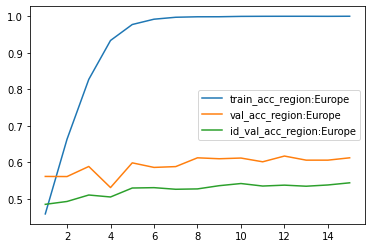

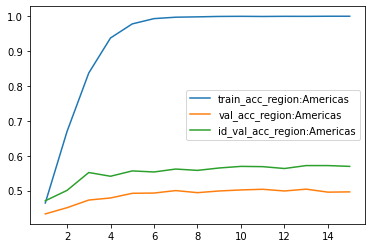

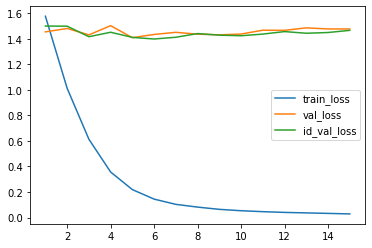

In [9]:
metrics = list(train_evolution[0].keys())

for metric in metrics:
	plot_graph(metric, train_evolution, val_evolution, id_val_evolution, NUM_EPOCHS)